# Imports

In [20]:
#Imports
#numpy, pandas, scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt

#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model

#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

#cross validation - replaced "cross_validation" with "model_selection" per: https://stackoverflow.com/questions/30667525/importerror-no-module-named-sklearn-cross-validation
from sklearn.model_selection import train_test_split

# Import Data

In [21]:
#data
rawData = pd.read_csv('credit2.csv', header=1)
rawData.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1.0,20000,female,university,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,default
1,2.0,120000,female,university,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,default
2,3.0,90000,female,university,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,not default
3,4.0,50000,female,university,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,not default
4,5.0,50000,male,university,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,not default


In [22]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  float64
 1   LIMIT_BAL                   30001 non-null  object 
 2   SEX                         30001 non-null  object 
 3   EDUCATION                   30001 non-null  object 
 4   MARRIAGE                    30001 non-null  object 
 5   AGE                         30001 non-null  object 
 6   PAY_0                       30001 non-null  object 
 7   PAY_2                       30001 non-null  object 
 8   PAY_3                       30001 non-null  object 
 9   PAY_4                       30001 non-null  object 
 10  PAY_5                       30001 non-null  object 
 11  PAY_6                       30001 non-null  object 
 12  BILL_AMT1                   30001 non-null  object 
 13  BILL_AMT2                   300

# Clean Data

In [23]:
#Row 201 is bad and needs to be dropped:
rawData.drop(rawData[rawData.ID.isnull()].index, axis=0, inplace=True)

In [24]:
numeric_cols = list(rawData.columns[5:-1])
rawData[numeric_cols] = rawData[numeric_cols].astype(int)
rawData['LIMIT_BAL'] = rawData['LIMIT_BAL'].astype(int)

In [25]:
rawData.describe()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,...,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,8660.398374,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,...,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,1.000000,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,...,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,...,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,15000.500000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,...,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,22500.250000,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,...,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,30000.000000,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,...,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [26]:
#now data types are (mostly) int64
rawData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 30000
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  float64
 1   LIMIT_BAL                   30000 non-null  int64  
 2   SEX                         30000 non-null  object 
 3   EDUCATION                   30000 non-null  object 
 4   MARRIAGE                    30000 non-null  object 
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  int64  
 13  BILL_AMT2                   300

# Adding Dummies 

In [27]:
rawData = pd.get_dummies(rawData)

In [28]:
rawData.head()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,default payment next month_default,default payment next month_not default
0,1.0,20000,24,2,2,-1,-1,-2,-2,3913,...,0,0,0,1,0,1,0,0,1,0
1,2.0,120000,26,-1,2,0,0,0,2,2682,...,0,0,0,1,0,0,1,0,1,0
2,3.0,90000,34,0,0,0,0,0,0,29239,...,0,0,0,1,0,0,1,0,0,1
3,4.0,50000,37,0,0,0,0,0,0,46990,...,0,0,0,1,0,1,0,0,0,1
4,5.0,50000,57,-1,0,-1,0,0,0,8617,...,0,0,0,1,0,1,0,0,0,1


# Correlation

In [29]:
rawData.corr()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,default payment next month_default,default payment next month_not default
ID,1.000000,0.026179,0.018678,-0.030575,-0.011215,-0.018494,-0.002735,-0.022199,-0.020270,0.019389,...,-0.025858,0.017475,0.037165,0.002569,0.003704,0.026687,-0.023794,-0.015255,-0.013952,0.013952
LIMIT_BAL,0.026179,1.000000,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,-0.235195,0.285430,...,0.258777,-0.139686,0.013420,-0.147530,-0.011299,0.103701,-0.090998,-0.055806,-0.153520,0.153520
AGE,0.018678,0.144713,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,-0.048773,0.056239,...,-0.100423,0.231252,0.008982,-0.077626,0.010731,0.449425,-0.466584,0.082771,0.013890,-0.013890
PAY_0,-0.030575,-0.271214,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,0.474553,0.187068,...,-0.142720,0.058902,-0.024937,0.099177,-0.005667,-0.016314,0.013173,0.017358,0.324794,-0.324794
PAY_2,-0.011215,-0.296382,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,0.575501,0.234887,...,-0.169215,0.064590,-0.033118,0.122364,-0.002481,-0.022525,0.020281,0.011657,0.263551,-0.263551
PAY_3,-0.018494,-0.286123,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,0.632684,0.208473,...,-0.160209,0.062461,-0.034435,0.115644,-0.001331,-0.030584,0.027195,0.016646,0.235253,-0.235253
PAY_4,-0.002735,-0.267460,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,0.716449,0.202812,...,-0.152402,0.058382,-0.030998,0.110340,-0.005438,-0.030167,0.026955,0.017481,0.216614,-0.216614
PAY_5,-0.022199,-0.249411,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,0.816900,0.206684,...,-0.138709,0.049577,-0.028822,0.103218,-0.005292,-0.034081,0.032107,0.011396,0.204149,-0.204149
PAY_6,-0.020270,-0.235195,-0.048773,0.474553,0.575501,0.632684,0.716449,0.816900,1.000000,0.207373,...,-0.125123,0.041370,-0.035733,0.098013,-0.004979,-0.031772,0.028763,0.016297,0.186866,-0.186866
BILL_AMT1,0.019389,0.285430,0.056239,0.187068,0.234887,0.208473,0.202812,0.206684,0.207373,1.000000,...,-0.024045,-0.022006,0.036364,0.030323,-0.017775,0.025264,-0.021347,-0.011401,-0.019644,0.019644


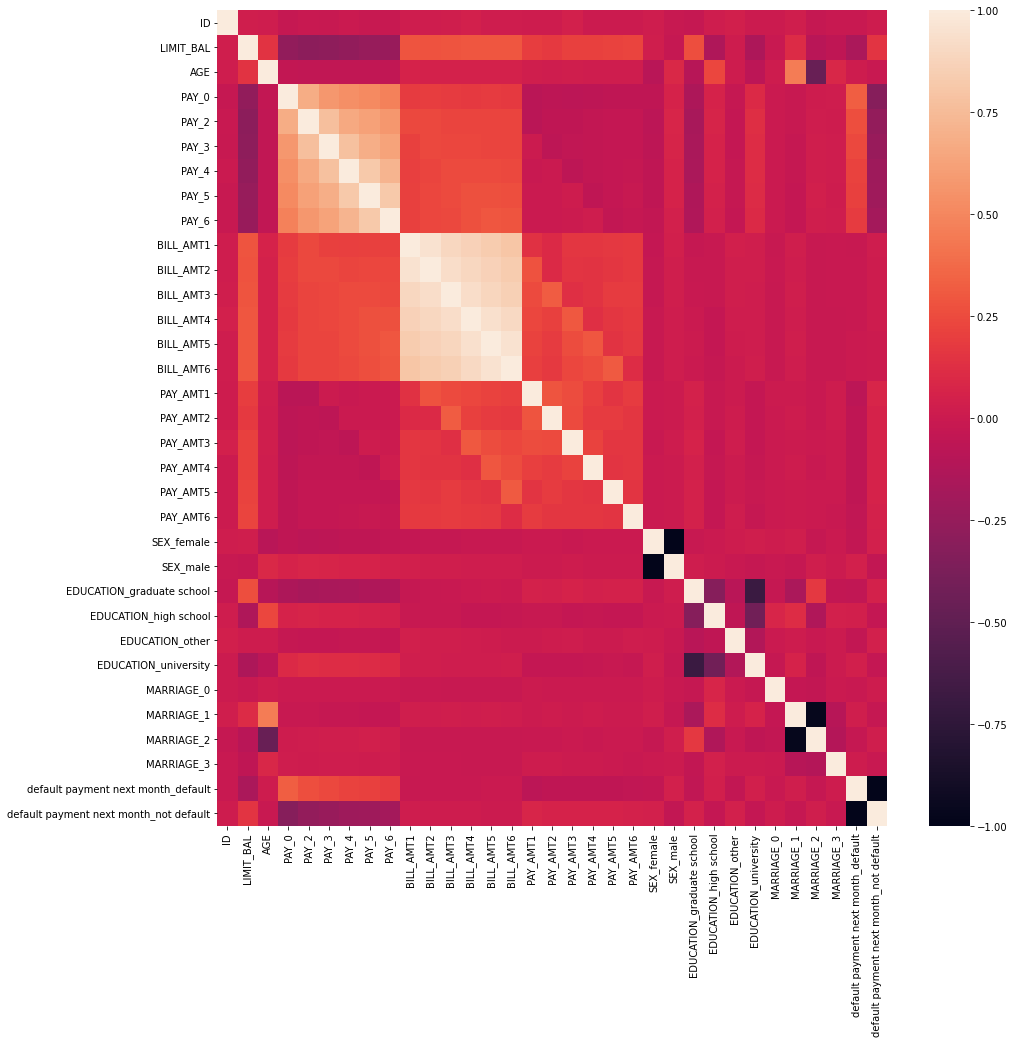

In [30]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(rawData.corr())
plt.show()

# Covariance

In [31]:
rawData.cov()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,default payment next month_default,default payment next month_not default
ID,7.500250e+07,2.941664e+07,1491.057019,-297.572636,-116.276959,-191.692156,-27.691323,-217.860029,-201.877379,1.236447e+07,...,-107.013617,56.025184,39.886696,11.101737,1.359579,115.098587,-102.823394,-13.634771,-50.151705,50.151705
LIMIT_BAL,2.941664e+07,1.683446e+10,173076.722569,-39545.930009,-46037.648360,-44432.253315,-40571.811859,-36670.562325,-35093.083441,2.727020e+09,...,16044.482969,-6709.314796,215.785093,-9550.953266,-62.140519,6700.677912,-5891.264611,-747.272783,-8267.551759,8267.551759
AGE,1.491057e+03,1.730767e+05,84.969755,-0.408639,-0.553408,-0.585263,-0.535851,-0.562245,-0.517022,3.817293e+04,...,-0.442349,0.789120,0.010260,-0.357031,0.004193,2.063121,-2.146056,0.078742,0.053143,-0.053143
PAY_0,-2.975726e+02,-3.954593e+04,-0.408639,1.262930,0.904330,0.772384,0.707972,0.648743,0.613292,1.548030e+04,...,-0.076644,0.024505,-0.003473,0.055612,-0.000270,-0.009130,0.007387,0.002013,0.151499,-0.151499
PAY_2,-1.162770e+02,-4.603765e+04,-0.553408,0.904330,1.433254,1.098371,0.926680,0.844886,0.792320,2.070661e+04,...,-0.096806,0.028625,-0.004913,0.073094,-0.000126,-0.013430,0.012115,0.001440,0.130960,-0.130960
PAY_3,-1.916922e+02,-4.443225e+04,-0.585263,0.772384,1.098371,1.432492,1.087761,0.931455,0.870815,1.837321e+04,...,-0.091629,0.027674,-0.005107,0.069062,-0.000068,-0.018230,0.016241,0.002056,0.116867,-0.116867
PAY_4,-2.769132e+01,-4.057181e+04,-0.535851,0.707972,0.926680,1.087761,1.366885,1.086161,0.963263,1.746020e+04,...,-0.085144,0.025268,-0.004491,0.064367,-0.000269,-0.017564,0.015725,0.002109,0.105115,-0.105115
PAY_5,-2.178600e+02,-3.667056e+04,-0.562245,0.648743,0.844886,0.931455,1.086161,1.284114,1.064545,1.724638e+04,...,-0.075112,0.020798,-0.004047,0.058361,-0.000254,-0.019233,0.018154,0.001333,0.096020,-0.096020
PAY_6,-2.018774e+02,-3.509308e+04,-0.517022,0.613292,0.792320,0.870815,0.963263,1.064545,1.322472,1.756042e+04,...,-0.068759,0.017612,-0.005092,0.056240,-0.000243,-0.018196,0.016505,0.001934,0.089194,-0.089194
BILL_AMT1,1.236447e+07,2.727020e+09,38172.933546,15480.304170,20706.614217,18373.210469,17460.198259,17246.377531,17560.424872,5.422240e+09,...,-846.084922,-599.858730,331.829532,1114.114120,-55.482745,926.474490,-784.346061,-86.645684,-600.394108,600.394108


# Part 2: Default as Dependent Variable

# Selecting Data

In [32]:
#features
X = rawData[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
print('Summary of feature sample')
X.head()

Summary of feature sample


,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0


In [33]:
#dependent variable
y = rawData['default payment next month_default']
y.head()

0    1
1    1
2    0
3    0
4    0
Name: default payment next month_default, dtype: uint8

# Modeling Format

In [34]:
algosClass = []

In [35]:
algosClass.append(('Random Forest Regressor 1',RandomForestRegressor()))

In [36]:
algosClass.append(('Random Forest Regressor 2',RandomForestRegressor(n_estimators=10, max_depth=3)))

In [37]:
algosClass.append(('Linear Regression',LinearRegression()))

In [38]:
algosClass.append(('Support Vector Regression 1',SVR()))

In [39]:
algosClass.append(('Support Vector Regression 2',SVR(kernel='poly', degree=3)))

In [40]:
#regression
results = []
names = []
for name, model in algosClass:
    print(name)
    result = cross_val_score(model, X,y, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

Random Forest Regressor 1
Random Forest Regressor 2
Linear Regression
Support Vector Regression 1
Support Vector Regression 2


In [48]:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 1 0.1729024831648531
Random Forest Regressor 2 0.19287885583968364
Linear Regression 0.1082410852560141
Support Vector Regression 1 0.12400102992092754
Support Vector Regression 2 -0.009912009731082342


# ...Pass the training data to it...

In [49]:
algo = RandomForestRegressor(n_estimators=10, max_depth=3)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [51]:
model = algo.fit(X_train,y_train)

# Making Predictions

In [52]:
predictions = model.predict(X_test)

# Establish a variable and calculate R squared

In [53]:
#Make Predictions
predictions = model.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: 0.194
RMSE: 0.373


# Plotting the Results

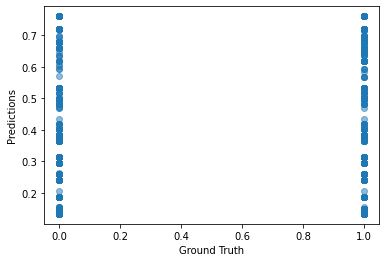

In [54]:
plt.scatter(y_test, predictions, alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

# Part 2: Limit Balance as Dependent Variable

# Selecting the Data:

In [55]:
#dependent variable
y = rawData['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

# Modeling Format:

In [56]:
algosClass = []

In [57]:
algosClass.append(('Random Forest Regressor 1',RandomForestRegressor()))

In [58]:
algosClass.append(('Random Forest Regressor 2',RandomForestRegressor(n_estimators=10, max_depth=3)))

In [59]:
algosClass.append(('Linear Regression',LinearRegression()))

In [60]:
algosClass.append(('Support Vector Regression 1',SVR()))

In [61]:
algosClass.append(('Support Vector Regression 2',SVR(kernel='poly', degree=3)))

In [62]:
#regression
results = []
names = []
for name, model in algosClass:
    print(name)
    result = cross_val_score(model, X,y, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

Random Forest Regressor 1
Random Forest Regressor 2
Linear Regression
Support Vector Regression 1
Support Vector Regression 2


In [63]:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 1 0.105491003481239
Random Forest Regressor 2 0.11290799741663667
Linear Regression 0.101961724682885
Support Vector Regression 1 -0.050732632640690355
Support Vector Regression 2 -0.03392222000409325


# ...Pass the training data to it...

In [64]:
algo = RandomForestRegressor(n_estimators=10, max_depth=3)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [66]:
model = algo.fit(X_train,y_train)

# Making Predictions


In [67]:
predictions = model.predict(X_test)

In [68]:
#Make Predictions
predictions = model.predict(X_test)
predRsquared = r2_score(y_test,predictions)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: 0.117
RMSE: 121145.928


# Plotting the Results

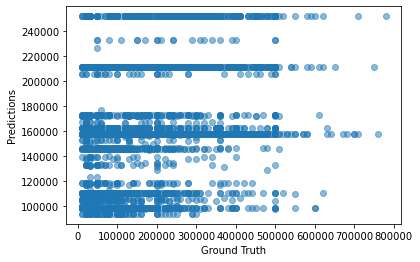

In [69]:
plt.scatter(y_test, predictions, alpha = 0.5)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()